In [17]:
import sys
import itertools
import time
import numpy as np
import pandas as pd
import psycopg2
import matplotlib.pyplot as plt
import scipy.stats as stats
sys.path.append("H:\chcd_py")
from chcd_py.helpers.db_utils import get_dsn
from chcd_py.helpers.helpers import explain_query, timer_profile, query_comparison_profiler

In [9]:
@timer_profile
def ndc_equal_query(cursor, ind_var, arg):
    '''performs a simple count equal query'''
    cursor.execute(f'select count(*) from {ind_var} where ndc = %s', (arg, ))
    return cursor.fetchall()


@timer_profile
def ndc_equal_by_source_query(cursor, ind_var, arg):
    '''performs a simple count of a single diagnosis query'''
    cursor.execute(f'select count(*) from {ind_var} where ndc = %s and data_source = %s', arg)
    return cursor.fetchall()


@timer_profile
def ndc_in_query(cursor, ind_var, arg):
    cursor.execute(f'select count(*) from {ind_var} where ndc in (%s, %s, %s)', arg)
    return cursor.fetchall()


@timer_profile
def ndc_in_by_source_query(cursor, ind_var, arg):
    cursor.execute(f'select count(*) from {ind_var} where ndc in (%s, %s, %s) and data_source = %s', arg)
    return cursor.fetchall()


@timer_profile
def ndc_join_query(cursor, ind_var, arg):
    cursor.execute('drop table if exists dev.gm_ndc_temp;')
    cursor.execute(f"""
create table dev.gm_ndc_temp as 
select ndc from dev.gm_ndc_temp_total  
where ndc like %s ESCAPE ''""", 
                   (arg[:7]+'%',))
    cursor.execute(f'''select count(*) from {ind_var} as rx
    inner join dev.gm_ndc_temp tmp on rx.ndc = tmp.ndc''', (arg,))
    return cursor.fetchall()

In [18]:
con = psycopg2.connect(get_dsn())
con.autocommit = True

In [5]:
np.random.seed(1)

ndc_codes = ['68462062594', '62991405201', '00527172791', '00240023004',
             '65862006301', '00781560731', '64679055702', '68405802116',
             '62011003001', '81131083748', '50268054015', '00054025922', 
             '58160082551', '54868215401', '00002306115', '00472127094', 
             '67112030190', '87701040021', '49452465801', '00013010101']

data_source_list= ['optz', 'optd', 'truv','mdcd', 'mcrn', 'mcrt']

ndc_code_data_source_combos = []

for ndc_code in ndc_codes:
    for data_source in data_source_list:
        ndc_code_data_source_combos.append((ndc_code, data_source))
        
sample_size = 20
        
np.random.shuffle(ndc_code_data_source_combos)
ndc_code_data_source_combos = ndc_code_data_source_combos[:sample_size]

#for in query
ndc_in_codes_combo = list(itertools.combinations(ndc_codes,3))
np.random.shuffle(ndc_in_codes_combo)
ndc_in_codes_combo = ndc_in_codes_combo[:sample_size]
ndc_source_in_combo = [i + (np.random.choice(data_source_list, 1)[0],) for i in ndc_in_codes_combo]


table_list = ['dev.gm_pharmacy_claims', 'data_warehouse.pharmacy_claims']

x_labels = ['Index and Partition', 'Partition Only']

## Notes

Data size on 2022/02/17 for pharmacy claims is ~1.7 tb

~145k unique ndc codes

## select count(*) from {pharmacy_table} where ndc = %s

****************************************

,Index and Partition,Partition Only,args,query_results
0,0.234928,26.305162,68462062594,3
1,0.043168,26.427538,62991405201,46
2,0.032976,26.702826,00527172791,29
3,0.032195,26.967437,00240023004,1
4,0.673482,26.270423,65862006301,482666
5,0.155997,26.387513,00781560731,47794
6,0.099965,26.920872,64679055702,17480
7,0.035846,26.298799,68405802116,19
8,0.039464,26.450351,62011003001,31
9,0.037471,26.408855,81131083748,13


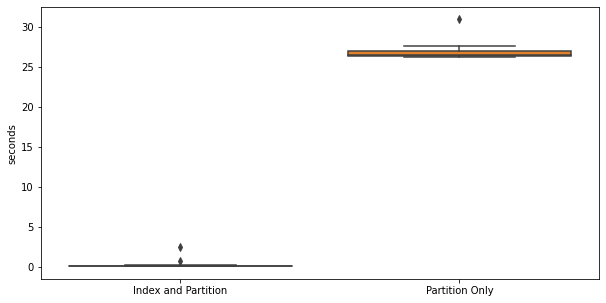

In [19]:
results = query_comparison_profiler(con, table_list, ndc_equal_query, ndc_codes, x_labels)
results

In [20]:
results_description = results.describe()
results_description[x_labels].round(decimals=2)

,Index and Partition,Partition Only
count,20.00,20.00
mean,0.22,26.83
std,0.55,1.03
min,0.03,26.22
25%,0.03,26.31
50%,0.04,26.46
75%,0.11,26.93
max,2.49,30.93


In [21]:
tvalue, pvalue = stats.ttest_rel(results['Partition Only'], 
                                 results['Index and Partition'])
print(tvalue, pvalue)

98.36359688744784 3.4154537569458605e-27


## select count(*) from {pharmacy_table} where ndc = %s and data_source = %s

****************************************

,Index and Partition,Partition Only,args,query_results
0,0.139001,1.481355,"(00472127094, mcrt)",122
1,0.027295,8.503359,"(81131083748, optz)",0
2,0.023486,1.717714,"(81131083748, mcrt)",0
3,0.056649,2.293877,"(00013010101, mdcd)",284
4,0.025156,1.948933,"(58160082551, mcrt)",0
5,0.024432,1.489621,"(68405802116, mcrn)",0
6,0.081006,9.385802,"(00781560731, optd)",9136
7,0.022033,2.131353,"(54868215401, mdcd)",0
8,0.020471,9.568309,"(62011003001, optz)",1
9,0.025330,10.389586,"(67112030190, truv)",123


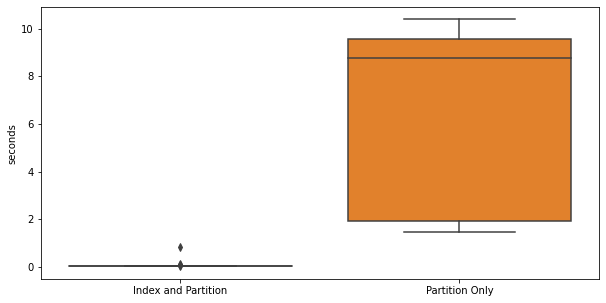

In [21]:

results = query_comparison_profiler(con, table_list, ndc_equal_by_source_query, 
                                    ndc_code_data_source_combos, x_labels)
results

In [22]:
results_description = results.describe()
results_description[x_labels].round(decimals=2)

,Index and Partition,Partition Only
count,20.00,20.00
mean,0.08,6.04
std,0.18,3.91
min,0.02,1.48
25%,0.02,1.92
50%,0.02,8.79
75%,0.03,9.55
max,0.85,10.39


In [23]:
tvalue, pvalue = stats.ttest_rel(results['Partition Only'], 
                                 results['Index and Partition'])
print(tvalue, pvalue)

6.880852952514632 1.4556553994192186e-06


## select count(*) from {pharmacy_table} where ndc in (%s, %s, %s) 

****************************************

,Index and Partition,Partition Only,args,query_results
0,0.899031,26.262992,"(65862006301, 00472127094, 00013010101)",648040
1,0.105410,27.216541,"(68462062594, 64679055702, 62011003001)",17514
2,2.518631,26.356465,"(62991405201, 00240023004, 00054025922)",3482032
3,2.495330,26.444376,"(68462062594, 00054025922, 58160082551)",3482003
4,0.845104,27.400569,"(00527172791, 65862006301, 00781560731)",530489
5,0.117132,26.192212,"(64679055702, 81131083748, 67112030190)",18066
6,0.048949,26.107711,"(00240023004, 81131083748, 67112030190)",587
7,0.103264,41.161020,"(64679055702, 62011003001, 50268054015)",17526
8,0.851384,27.420516,"(62991405201, 65862006301, 00781560731)",530506
9,0.046415,28.429080,"(62991405201, 00240023004, 49452465801)",48


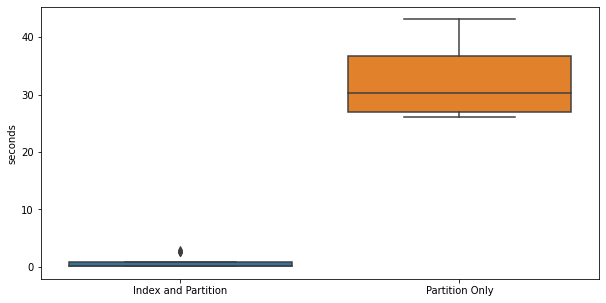

In [30]:
ndc_in_results = query_comparison_profiler(con, table_list, ndc_in_query, 
                                           ndc_in_codes_combo, x_labels)
ndc_in_results

In [31]:
ndc_in_description = ndc_in_results.describe()
ndc_in_description[x_labels].round(decimals=2)

,Index and Partition,Partition Only
count,20.00,20.00
mean,0.78,32.01
std,1.01,5.88
min,0.04,26.11
25%,0.05,27.02
50%,0.15,30.21
75%,0.86,36.64
max,2.96,43.11


In [32]:
tvalue, pvalue = stats.ttest_rel(ndc_in_description['Partition Only'], 
                                 ndc_in_description['Index and Partition'])
print(tvalue, pvalue)

4.806051511129117 0.001952602196602206


## select count(*) from {pharmacy_table} where ndc in (%s, %s, %s) and data_source = '%s'

****************************************

,Index and Partition,Partition Only,args,query_results
0,0.439357,9.971020,"(65862006301, 00472127094, 00013010101, optd)",134201
1,0.093812,2.240256,"(68462062594, 64679055702, 62011003001, mdcd)",10192
2,0.860541,9.073657,"(62991405201, 00240023004, 00054025922, optz)",714044
3,1.128366,9.734252,"(68462062594, 00054025922, 58160082551, truv)",1228674
4,0.332432,9.077154,"(00527172791, 65862006301, 00781560731, optz)",140977
5,0.048225,1.467056,"(64679055702, 81131083748, 67112030190, mcrn)",405
6,0.033639,1.504714,"(00240023004, 81131083748, 67112030190, mcrn)",0
7,0.108897,2.192696,"(64679055702, 62011003001, 50268054015, mdcd)",10192
8,0.185833,1.787519,"(62991405201, 65862006301, 00781560731, mcrt)",52871
9,0.036068,1.836184,"(62991405201, 00240023004, 49452465801, mcrt)",0


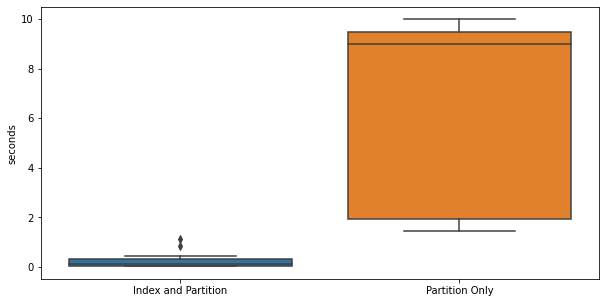

In [33]:
ndc_source_in_results = query_comparison_profiler(con, table_list, ndc_in_by_source_query, 
                                                  ndc_source_in_combo, x_labels)
ndc_source_in_results

In [34]:
ndc_source_in_description = ndc_source_in_results.describe()
ndc_source_in_description[x_labels].round(decimals=2)

,Index and Partition,Partition Only
count,20.00,20.00
mean,0.23,6.02
std,0.30,3.90
min,0.02,1.47
25%,0.03,1.95
50%,0.10,9.00
75%,0.34,9.47
max,1.13,9.98


In [35]:
tvalue, pvalue = stats.ttest_rel(ndc_source_in_results['Partition Only'], 
                                 ndc_source_in_results['Index and Partition'])
print(tvalue, pvalue)

6.766362948462113 1.8333080223220127e-06


## Join Query

****************************************

,Index and Partition,Partition Only,args,query_results
0,1.981643,33.832768,68462062594,1159757
1,0.842292,33.545224,62991405201,11144
2,0.903330,34.178353,00527172791,464794
3,0.148564,33.995084,00240023004,1
4,70.121307,34.223384,65862006301,100938790
5,4.578039,33.899345,00781560731,4558864
6,3.223493,33.990710,64679055702,3094498
7,0.339746,33.638665,68405802116,2635
8,0.560276,33.931640,62011003001,30927
9,0.193495,33.859219,81131083748,111


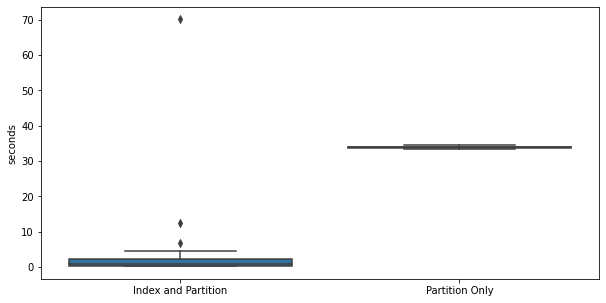

In [13]:
join_results = query_comparison_profiler(con, table_list, ndc_join_query, 
                                         ndc_codes, x_labels)
join_results

In [14]:
dx_join_description = join_results.describe()
dx_join_description[x_labels].round(decimals=2)

,Index and Partition,Partition Only
count,20.00,20.00
mean,5.30,33.89
std,15.55,0.27
min,0.15,33.43
25%,0.29,33.68
50%,0.70,33.88
75%,2.29,34.01
max,70.12,34.45


In [15]:
tvalue, pvalue = stats.ttest_rel(join_results['Partition Only'], 
                                 join_results['Index and Partition'])
print(tvalue, pvalue)

8.265382380701999 1.028701004723157e-07
